## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from typing import List
from codes.utils import get_n_classes_2d_toy_dataset, plot_2d_toy_dataset, plot_losses_and_accuracies, train_model_for_toy_dataset
from codes.utils import plot_boundries_per_class, plot_boundries, plot_ignorance_uncertainity_confusion

from codes.loss import custom_loss, calculate_only_belief_uncertainity_ignorance_confusion

# and set the seed for reproducibility
random_seed = 42
random.seed(random_seed)

## Create the MLP model for classifying the 2D points

In [2]:
class MLP(nn.Module):
    def __init__(self,
                 last_layer_activation: nn.Module,
                 input_dim: int,
                 hidden_dims: List[int],
                 output_dims: int,
                 activation: nn.Module = nn.LeakyReLU(0.2)):
        super(MLP, self).__init__()

        self.last_layer_activation = last_layer_activation

        counter = 0

        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            current_fc_layer = nn.Linear(prev_dim, hidden_dim)
            setattr(self, f'fc_{counter}', current_fc_layer)
            counter += 1
            prev_dim = hidden_dim
        
        last_fc_layer = nn.Linear(prev_dim, output_dims)

        setattr(self, f'fc_{counter}', last_fc_layer)

        self.activation = activation

        self.layer_count = counter + 1
    
    def forward(self, x):
        
        for i in range(self.layer_count):
            x = getattr(self, f'fc_{i}')(x)
            if i != self.layer_count - 1:
                x = self.activation(x)
            else:
                x = self.last_layer_activation(x)
        return x

## Generate the 2D toy dataset

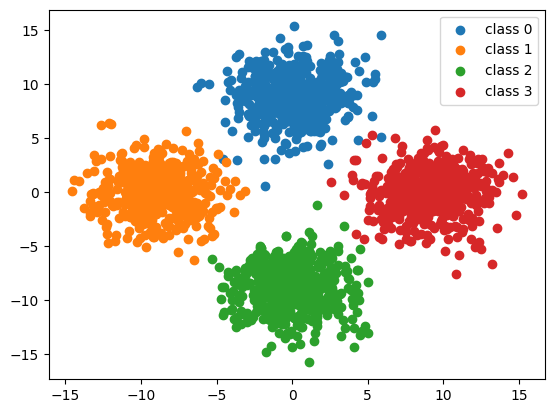

In [3]:
# Generate some data
n_classes = 4
n_samples_per_class = 500
std = 2
distance = 9
shuffle = True

# set the seed again
random.seed(random_seed)

# Generate the data
X, y = get_n_classes_2d_toy_dataset(n_classes=n_classes,
                                    n_samples_per_class=n_samples_per_class,
                                    std=std,
                                    distance=distance,
                                    random_seed=random_seed,
                                    shuffle=shuffle)

plot_2d_toy_dataset(X, y, n_classes)

## Get the data ready for training

In [4]:
# Split the data into training and test validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# convert labels to one-hot encoding
y_train = np.eye(n_classes)[y_train]
y_validation = np.eye(n_classes)[y_validation]

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)

# print the first 10 data
print(X_train[:10])
print(y_train[:10])

tensor([[  0.7611,   9.2100],
        [ -2.6996, -11.8202],
        [ -9.6615,  -0.1125],
        [ -8.1291,   0.2027],
        [  1.9727,   7.1587],
        [  0.3380,   8.4027],
        [  0.6343,   9.1875],
        [ -8.8596,   2.1373],
        [  3.5563,  10.6616],
        [ -8.4578,  -0.7735]])
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]])


## Define 2 exact MLP models

In [5]:
# create the MLP which will be trained with the classic loss
MLP_classic = MLP(input_dim=2,
                  hidden_dims=[16],
                  output_dims=n_classes,
                  activation=nn.LeakyReLU(0.2),
                  last_layer_activation=nn.Softmax(dim=1))


# print the MLP
print("MLP with classic loss:")
print(MLP_classic)

MLP with classic loss:
MLP(
  (last_layer_activation): Softmax(dim=1)
  (fc_0): Linear(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=4, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)


## Train the classic model

In [6]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the loss function for our loss
classic_loss_object = nn.CrossEntropyLoss()

# create the optimizer for the classic loss (SGD with momentum)
optimizer_classic = optim.SGD(MLP_classic.parameters(), lr=0.001, momentum=0.9)


train_loss_classic_loss, train_accuracy_classic_loss, validation_loss_classic_loss, validation_accuracy_classic_loss = train_model_for_toy_dataset(
    model=MLP_classic,
    optimizer=optimizer_classic,
    loss_fn=classic_loss_object,
    device=device,
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation,
    n_epochs=3000,
    verbose=True,
    verbose_every=500
)

Epoch 499:
Train loss: 0.7620351910591125, Train accuracy: 0.996874988079071
Validation loss: 0.7644402980804443, Validation accuracy: 0.9950000047683716

Epoch 999:
Train loss: 0.7554168701171875, Train accuracy: 0.996874988079071
Validation loss: 0.7573917508125305, Validation accuracy: 0.9950000047683716

Epoch 1499:
Train loss: 0.7530065774917603, Train accuracy: 0.996874988079071
Validation loss: 0.7548198699951172, Validation accuracy: 0.9975000023841858

Epoch 1999:
Train loss: 0.75171959400177, Train accuracy: 0.996874988079071
Validation loss: 0.7534682154655457, Validation accuracy: 0.9975000023841858

Epoch 2499:
Train loss: 0.750905454158783, Train accuracy: 0.996874988079071
Validation loss: 0.7526347041130066, Validation accuracy: 0.9975000023841858

Epoch 2999:
Train loss: 0.7503370642662048, Train accuracy: 0.996874988079071
Validation loss: 0.752073347568512, Validation accuracy: 0.9975000023841858



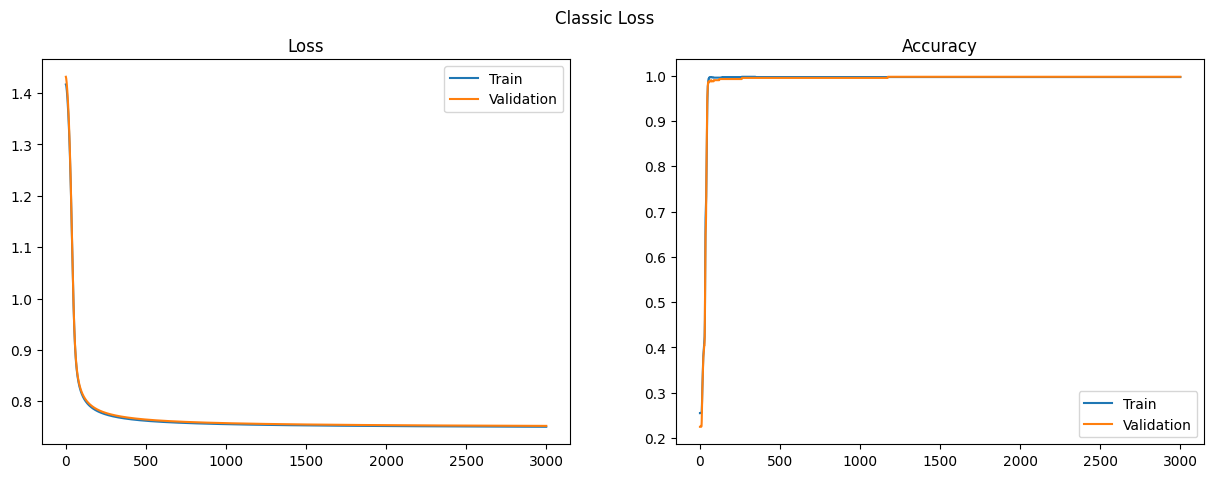

In [7]:
# plot the losses and accuracies
plot_losses_and_accuracies(train_loss_classic_loss,
                           train_accuracy_classic_loss, 
                           validation_loss_classic_loss,
                           validation_accuracy_classic_loss,
                           title="Classic Loss")

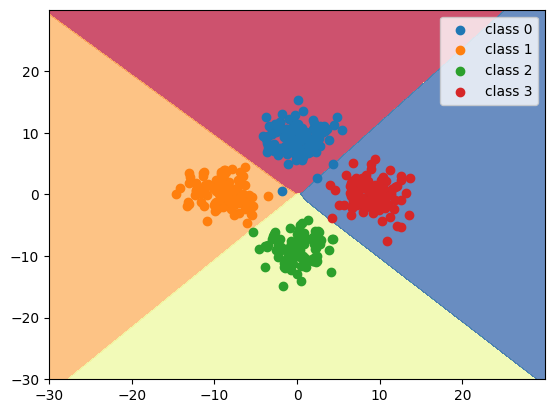

In [8]:
# plot the decision boundries
plot_boundries(MLP_classic,
    device = "cpu",
    X = X_validation,
    y = y_validation,
    n_classes=n_classes,
    plot_step=0.02,
    x_min=-30,
    x_max=30,
    y_min=-30,
    y_max=30
)

## Train the model with custom loss (the papers uncertainity loss)

In [9]:
# create the MLP which will be trained with the losses in the paper
MLP_with_our_loss = MLP(input_dim=2,
                   hidden_dims=[32, 16],
                   output_dims=n_classes,
                   activation=nn.ReLU(),
                   last_layer_activation=nn.Sigmoid())

# print the MLP
print("\nMLP with our loss:")
print(MLP_with_our_loss)


MLP with our loss:
MLP(
  (last_layer_activation): Sigmoid()
  (fc_0): Linear(in_features=2, out_features=32, bias=True)
  (fc_1): Linear(in_features=32, out_features=16, bias=True)
  (fc_2): Linear(in_features=16, out_features=4, bias=True)
  (activation): ReLU()
)


In [10]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the loss function for our loss
our_loss_object = custom_loss(
    max_epochs=500,
    max_lambda_kl=0.05,
    annealing_last_value=0.0,
    n_classes=n_classes,
    lambda_reg=1.0
)

# create the optimizer for the our loss (SGD with momentum)
optimizer_our_loss = optim.SGD(MLP_with_our_loss.parameters(), lr=0.0005, momentum=0.9)


train_loss_our_loss, train_accuracy_our_loss, validation_loss_our_loss, validation_accuracy_our_loss = train_model_for_toy_dataset(
    model=MLP_with_our_loss,
    optimizer=optimizer_our_loss,
    loss_fn=our_loss_object,
    device=device,
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation,
    n_epochs=4000,
    verbose=True,
    verbose_every=500
)

Epoch 499:
Train loss: 0.5665690302848816, Train accuracy: 0.9975000023841858
Validation loss: 0.6008628606796265, Validation accuracy: 0.9950000047683716

Epoch 999:
Train loss: 0.07623930275440216, Train accuracy: 0.9962499737739563
Validation loss: 0.08433689922094345, Validation accuracy: 0.9950000047683716

Epoch 1499:
Train loss: 0.041333965957164764, Train accuracy: 0.9962499737739563
Validation loss: 0.047384534031152725, Validation accuracy: 0.9950000047683716

Epoch 1999:
Train loss: 0.030560031533241272, Train accuracy: 0.9962499737739563
Validation loss: 0.03594699874520302, Validation accuracy: 0.9975000023841858

Epoch 2499:
Train loss: 0.025316821411252022, Train accuracy: 0.9962499737739563
Validation loss: 0.030485598370432854, Validation accuracy: 0.9975000023841858

Epoch 2999:
Train loss: 0.022207368165254593, Train accuracy: 0.9962499737739563
Validation loss: 0.027360664680600166, Validation accuracy: 0.9975000023841858

Epoch 3499:
Train loss: 0.02014383114874363

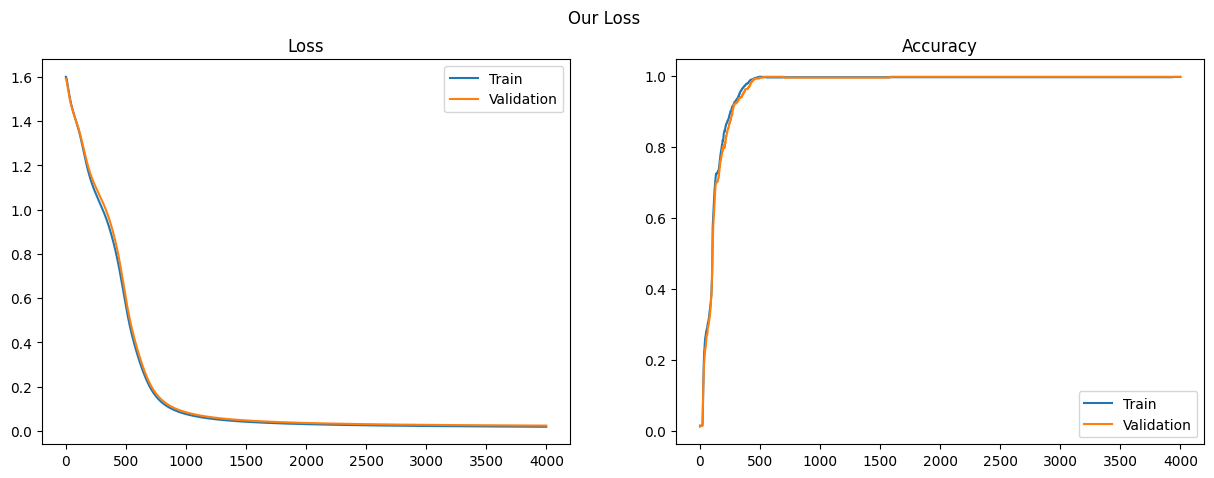

In [11]:
# plot the losses and accuracies
plot_losses_and_accuracies(
    train_loss_our_loss,
    train_accuracy_our_loss,
    validation_loss_our_loss,
    validation_accuracy_our_loss,
    title="Our Loss",
)

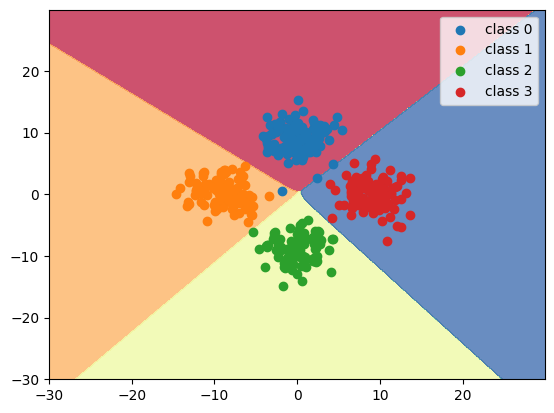

In [12]:
# plot the boundries
plot_boundries(
    model=MLP_with_our_loss,
    device="cpu",
    X=X_validation,
    y=y_validation,
    n_classes=n_classes,
    plot_step=0.05,
    x_min=-30,
    x_max=30,
    y_min=-30,
    y_max=30
)

## Visualize the confusion and ignorance values in boundries

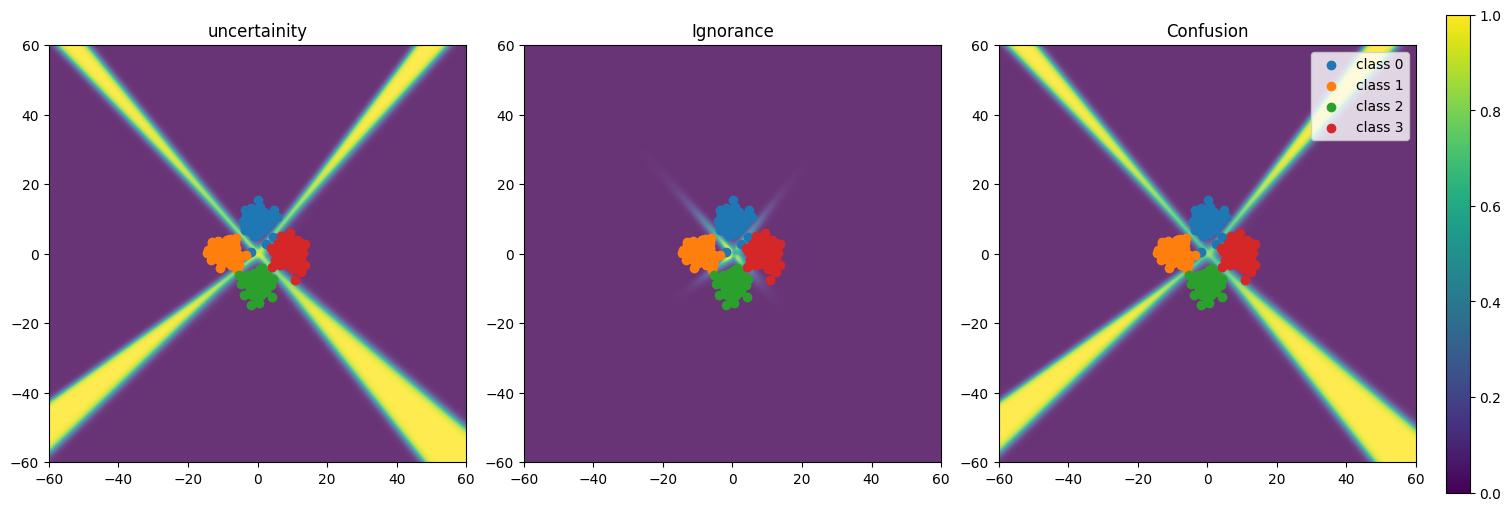

In [13]:
# plot the ignorance, uncertainity and confusion
plot_ignorance_uncertainity_confusion(
    model=MLP_with_our_loss,
    device="cpu",
    X=X_validation,
    y=y_validation,
    n_classes=n_classes,
    plot_step=0.05,
    x_min=-60,
    x_max=60,
    y_min=-60,
    y_max=60
)

In [19]:
# input a point and measure the beliefs, uncertainity, ignorance and confusion
x_sample = torch.tensor([[20, 20]], dtype=torch.float32)

y_pred_sample = MLP_with_our_loss(x_sample)

with torch.no_grad():
    beliefs, uncertainity, ignorance, confusion = calculate_only_belief_uncertainity_ignorance_confusion(y_pred_sample)


print(f"for the point ({x_sample[0,0]},{x_sample[0,1]}):")
print(f"plausibilities: {[float(x) for x in y_pred_sample.detach().numpy()[0]]}")
print(f"Beliefs: {[float(x) for x in beliefs.numpy()[0]]}")
print(f"Uncertainity: {uncertainity}")
print(f"Ignorance: {ignorance}")
print(f"Confusion: {confusion}")

print((1-y_pred_sample).prod())

for the point (20.0,20.0):
plausibilities: [0.981532633304596, 1.1895832355193064e-15, 4.810260296908651e-15, 0.9964575171470642]
Beliefs: [0.003349824110046029, 0.0, 0.0, 0.018271800130605698]
Uncertainity: tensor([0.9784])
Ignorance: tensor([6.5420e-05])
Confusion: tensor([0.9783])
tensor(6.5420e-05, grad_fn=<ProdBackward0>)
